# Look at DGEs, compare, annotate


### Import scanpy

In [1]:
import scanpy as sc
import scanpy.external as sce
import os,sys
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as mticker

In [2]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("utility_functions_190403_12h24/"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import, import after scanpy to overwrite rc.Params
import rz_utility_spring as srz

python version: 3.9.19


In [3]:
import warnings
warnings.filterwarnings( "ignore")

In [4]:
import matplotlib as mpl
mpl.rc('font',family='Arial')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# Load data 


In [6]:
adata = sc.read_h5ad('AML/data/AML_prec_only_206_2167x2000_250123_12h07.h5ad')    

In [7]:
# overwrite obs with the most recent version
filename = 'backups/AML_prec_only_206_clust__obs_info_2167x68_250123_16h50.npz'
encoding = 'latin1'

with np.load(filename,encoding=encoding, allow_pickle = True) as f:
    obs = pd.DataFrame(**f)
adata.obs = obs

In [8]:

adata.X.sum(axis=1)

matrix([[ 459.4988  ],
        [ 337.34085 ],
        [-479.11826 ],
        ...,
        [-292.71057 ],
        [ 257.36533 ],
        [ -41.697548]], dtype=float32)

In [9]:
adata_raw = sc.read_h5ad('AML/data/bb2_bb3_leiden_2.5_sub_DGE_refined_annotation_86447x37733_241107_10h51.h5ad')

In [10]:
adata_raw.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'ENSG00000238009', 'ENSG00000239945',
       'ENSG00000239906', 'ENSG00000241860', 'ENSG00000241599',
       'ENSG00000286448', 'ENSG00000236601',
       ...
       'ENSG00000275249', 'ENSG00000274792', 'ENSG00000274175',
       'ENSG00000275869', 'ENSG00000273554', 'ENSG00000277836',
       'ENSG00000278633', 'ENSG00000276017', 'ENSG00000278817',
       'ENSG00000277196'],
      dtype='object', length=37733)

In [11]:
adata.var_names_make_unique(join='_')

In [12]:
adata_raw.obs['unique_id'] = adata_raw.obs['barcode'].astype(str)+'_' + adata_raw.obs['library'].astype(str)

In [13]:
bdata = adata_raw[adata.obs.index, :].copy()

In [14]:
bdata.obsm = adata.obsm
bdata.uns = adata.uns
bdata.obsp = adata.obsp
bdata.obs = adata.obs

In [16]:
bdata.X = adata_raw[adata.obs.index, :].layers['counts']

In [17]:
bdata.X.sum(axis=1)

matrix([[9507.],
        [6196.],
        [ 607.],
        ...,
        [2547.],
        [5027.],
        [1663.]], dtype=float32)

### Scale (normalize) data

In [18]:
adata = bdata.copy()

In [19]:
adata.X.sum(axis=1)

matrix([[9507.],
        [6196.],
        [ 607.],
        ...,
        [2547.],
        [5027.],
        [1663.]], dtype=float32)

In [20]:
# turn into counts per 10k
print(adata.X[:5,:].sum(axis=1))
print()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
print(adata.X[:5,:].sum(axis=1))

[[9507.]
 [6196.]
 [ 607.]
 [ 521.]
 [2938.]]

[[10000.   ]
 [10000.001]
 [10000.   ]
 [10000.001]
 [ 9999.999]]


## Load DGE lists obtained with louvain res=0.5

In [22]:
dge_prec_only = pd.read_excel('AML/AML_precursors_louvain05_lists_enriched_genes_top_50_louvain_resolution_0.5_250123_17h13.xlsx',
                             index_col=0)

In [23]:
dge_prec_only[:5]

,1,1_FC,0,0_FC,4,4_FC,3,3_FC,5,5_FC,6,6_FC,2,2_FC,7,7_FC
0,DEFA4,2.324937,ENSG00000280441,2.062928,NAMPT,10.639332,OLFM4,2.771526,IL32,8.707201,DEFB1,13.909533,ANGPT1,6.295660,IGKC,75.245102
1,PDE4D,2.226799,ANKRD30BL,1.814738,S100A12,6.629262,LTF,2.332954,PRKCH,7.687298,VCAN,9.604497,MIR181A1HG,5.610987,IGHA1,58.620739
2,ABCA13,2.226110,ENSG00000278996,1.740135,LRRK2,5.685676,MMP8,2.291606,KLF12,7.566750,CTSG,5.502758,ENSG00000287092,5.220877,JCHAIN,42.463417
3,SLC22A15,2.208620,BACH2,1.631431,CR1,4.904157,NLRC4,2.126067,RORA,7.526011,LGALS1,5.026481,HTR1F,5.130796,IGLC2,17.552370
4,BPI,2.186727,ENSG00000282885,1.582043,NEAT1,4.766827,PADI4,2.105438,GNLY,7.025131,CD36,4.492570,FLT3,4.502407,TXNDC5,11.902231


In [24]:
#Load global DGE marker lists

dge_global_filt = pd.read_excel('AML/from_Denis/top100_dge_global_umap_sorted_by_FC_and_p_only_abund_genes.xlsx', 
                              index_col=0)

In [25]:
dge_global_filt[:5]

,AML Monocytes 1,AML Monocytes 2,AML cells 1,AML cells 10,AML cells 2,AML cells 3,AML cells 4,AML cells 5,AML cells 6,AML cells 7,...,NK cells,Naive B cells,Plasma cells,Platelets,Precursors of Neutrophils,Regulatory T cells,Tcm/Naive cytotoxic T cells,Tcm/Naive helper T cells,Tem/Effector helper T cells,Tem/Temra cytotoxic T cells
0,VCAN,FN1,ENSG00000224739,LINC02801,LINC00355,ENSG00000287616,SNCAIP,AGR2,XACT,MCM4,...,ENSG00000288970,TCL1A,IGHA1,ITGB3,E2F8,FOXP3,PTPRK-AS1,LEF1,NEFL,ENSG00000276241
1,VSIG4,NAV3,VSTM4,CNRIP1,ZNF385D,CRHBP,NEGR1,MNX1,GULP1,DTL,...,KLRF1,BANK1,JCHAIN,GP9,H3C2,RTKN2,LINC02446,TSHZ2,ADAM23,ZNF683
2,LYZ,PRL,SAMMSON,ENSG00000250696,ZNF560,BAALC,LINC02147,SPSB4,FGF10,GINS2,...,LINGO2,COL19A1,ENSG00000286848,TUBB1,H3C8,ENSG00000263655,NRCAM,EDAR,LINC02958,CCL5
3,PPARG,VCAN,GLI2,SLC24A3,ENSG00000253619,SCN3A,MAMDC2,SPOCK3,WDR86,CDC45,...,KLRC2,PAX5,IGHG1,LY6G6F,HJURP,LINC02694,NELL2,ANK3,ANK3,GZMH
4,MAFB,AMPH,PRDM16,TNFRSF19,ENPEP,MYRIP,ZNF521,CD34,ACSM3,PCLAF,...,KLRC3,IGHD,MZB1,CMTM5,RRM2,ENSG00000227240,CD8B,CAMK4,IATPR,SGCD


In [71]:
gene_dict_100_global = {}

for gsign in dge_global_filt.columns:
    gene_dict_100_global[gsign] = dge_global_filt[gsign].values.tolist()

In [72]:
gene_dict_100_global.keys()

dict_keys(['AML Monocytes 1', 'AML Monocytes 2', 'AML cells 1', 'AML cells 10', 'AML cells 2', 'AML cells 3', 'AML cells 4', 'AML cells 5', 'AML cells 6', 'AML cells 7', 'AML cells 8', 'AML cells 9', 'Aged Neutrophils', 'Basophils', 'CD14 Monocytes', 'CD14CD16 Monocytes', 'CD16 Monocytes', 'Dendritic cells', 'Early Immature Neutrophils', 'Erythrocytes', 'Immature Neutrophils', 'MAIT T cells', 'Mature Neutrophils', 'Memory B cells', 'NK cells', 'Naive B cells', 'Plasma cells', 'Platelets', 'Precursors of Neutrophils', 'Regulatory T cells', 'Tcm/Naive cytotoxic T cells', 'Tcm/Naive helper T cells', 'Tem/Effector helper T cells', 'Tem/Temra cytotoxic T cells'])

In [28]:
#load AML cells vs rest DGE results

dge_aml_filt = pd.read_excel('AML/from_Denis/top30_aml_markers_from_dge_only_AML_sorted_by_FC_and_p_only_abund_genes.xlsx', 
                              index_col=0)

In [29]:
gene_dict_30_aml = {}

for gsign in dge_aml_filt.columns:
    gene_dict_30_aml[gsign] = dge_aml_filt[gsign].values.tolist()
    

In [30]:
gene_dict_30_aml.keys()

dict_keys(['AML cells 1', 'AML cells 2', 'AML cells 3', 'AML cells 4', 'AML cells 5', 'AML cells 6', 'AML cells 7', 'AML cells 8', 'AML cells 9', 'AML cells 10'])

## Looking at our signatures

In [77]:
gene_dict_100_global['Primary_granules'] = ['MPO', 'ELANE', 'CTSG', 'PRTN3', 'AZU1']

In [78]:
for key in gene_dict_100_global.keys():
    sc.tl.score_genes(bdata, gene_list= gene_dict_100_global[key], ctrl_size=100,
                      score_name = key + '_score_global')


In [56]:
for key in gene_dict_30_aml.keys():
    sc.tl.score_genes(bdata, gene_list= gene_dict_30_aml[key], ctrl_size=30,
                      score_name = key + '_score_aml')


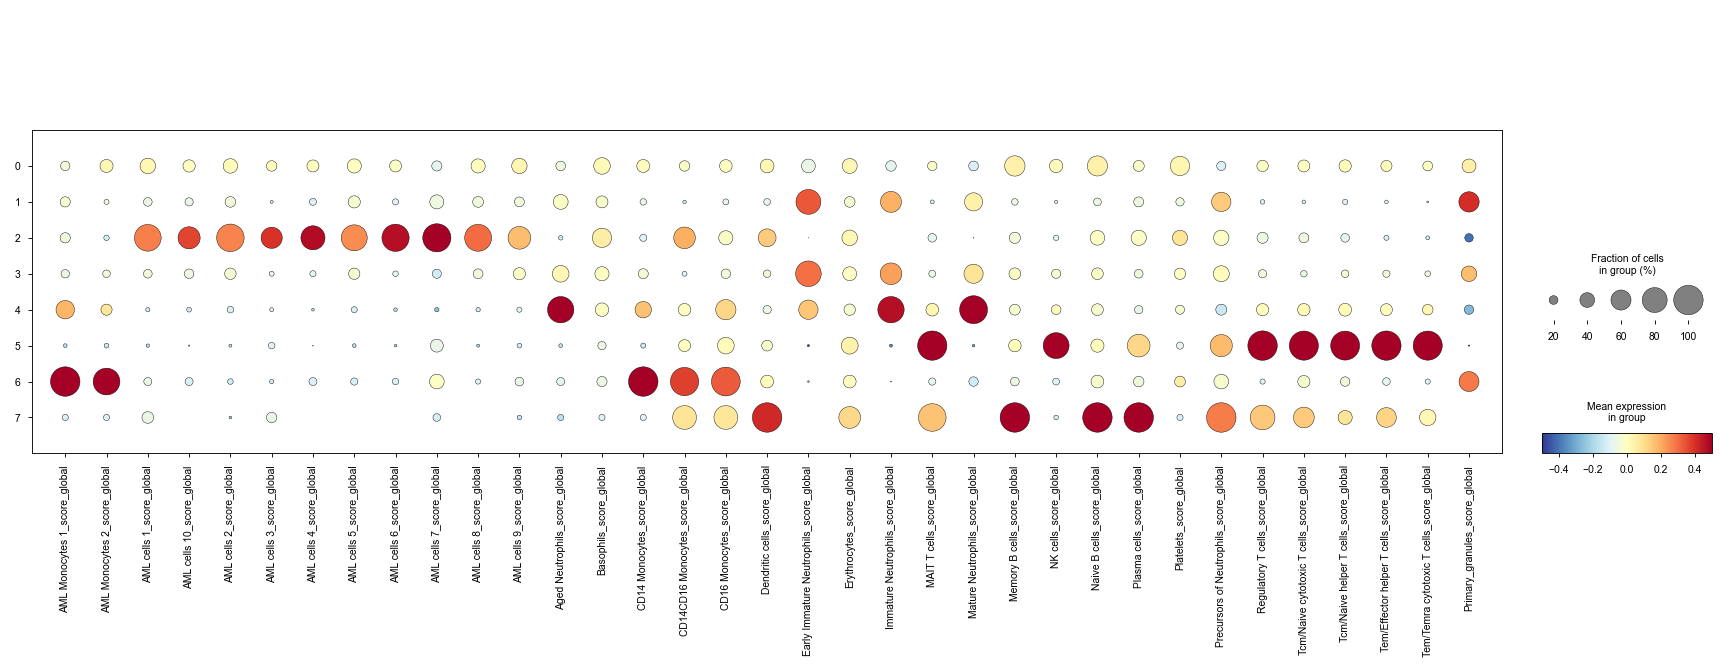

In [79]:
signatures_global=["AML Monocytes 1_score_global",
"AML Monocytes 2_score_global",
"AML cells 1_score_global",
"AML cells 10_score_global",
"AML cells 2_score_global",
"AML cells 3_score_global",
"AML cells 4_score_global",
"AML cells 5_score_global",
"AML cells 6_score_global",
"AML cells 7_score_global",
"AML cells 8_score_global",
"AML cells 9_score_global",
"Aged Neutrophils_score_global",
"Basophils_score_global",
"CD14 Monocytes_score_global",
"CD14CD16 Monocytes_score_global",
"CD16 Monocytes_score_global",
"Dendritic cells_score_global",
"Early Immature Neutrophils_score_global",
"Erythrocytes_score_global",
"Immature Neutrophils_score_global",
"MAIT T cells_score_global",
"Mature Neutrophils_score_global",
"Memory B cells_score_global",
"NK cells_score_global",
"Naive B cells_score_global",
"Plasma cells_score_global",
"Platelets_score_global",
"Precursors of Neutrophils_score_global",
"Regulatory T cells_score_global",
"Tcm/Naive cytotoxic T cells_score_global",
"Tcm/Naive helper T cells_score_global",
"Tem/Effector helper T cells_score_global",
"Tem/Temra cytotoxic T cells_score_global",
"Primary_granules_score_global"]

sc.pl.dotplot(bdata,signatures_global, groupby= 'louvain_resolution_0.5', vmin=-0.5, vmax=0.5,
             cmap="RdYlBu_r" )

## Annotate!

In [19]:
renamer = {
"0" : 'Precursors of Neutrophils',
"1" :  'Precursors of Neutrophils',
"2" : "Cycling AML cells 1",
"3" :  'Precursors of Neutrophils',
"4" : 'Early Immature Neutrophils',
"5" : 'Cycling T cells', 
"6" : "Cycling AML Monocytes",
"7" : "Cycling B cells"
    
}

In [20]:
bdata.obs['cell_type_refined2']= [renamer[i] for i in bdata.obs['louvain_resolution_0.5']]

In [21]:
bdata.obs['cell_type_refined2'][(bdata.obs['sample']=='UL')&(bdata.obs['louvain_resolution_0.5']=='0')]= 'Cycling AML cells 2'

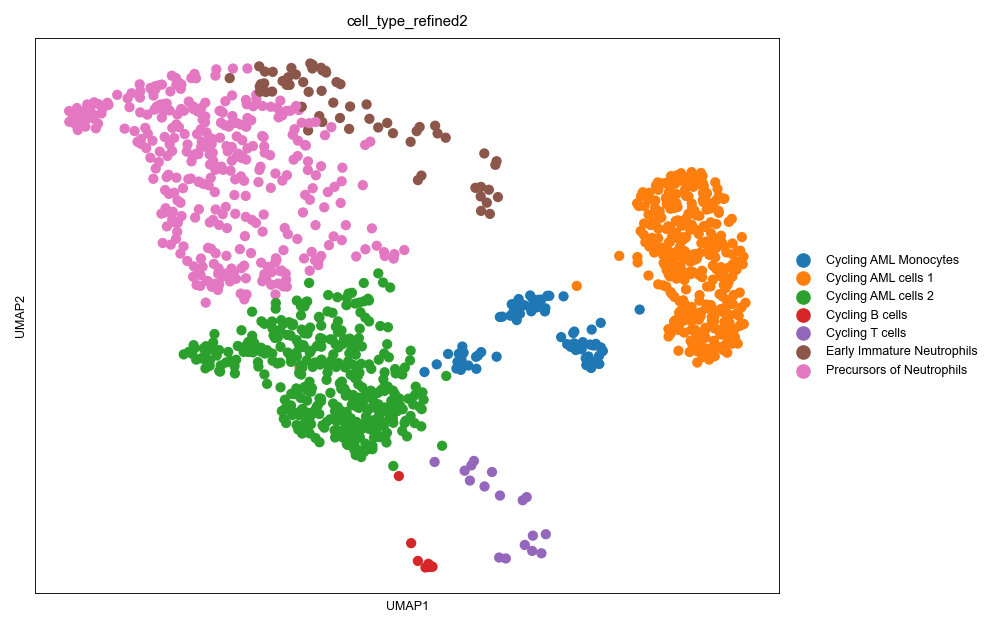

In [23]:
sc.pl.umap(bdata[UL_mask], color='cell_type_refined2')

In [155]:
bdata.obs['cell_type_refined2'].unique()

array(['Precursors of Neutrophils', 'Early Immature Neutrophils',
       'Cycling T cells', 'Cycling AML Monocytes', 'Cycling AML cells 1',
       'Cycling AML cells 2', 'Cycling B cells'], dtype=object)

In [158]:
 # Convert all labels to string

bdata.obs['cell_type_refined2'] = bdata.obs['cell_type_refined2'].astype(str) 
adata_raw.obs['cell_type_sub_prolif_anno'] = adata_raw.obs['cell_type_sub_prolif'].astype(str)


In [159]:
#update the values in global adata
adata_raw.obs['cell_type_sub_prolif_anno'].update(bdata.obs['cell_type_refined2'])

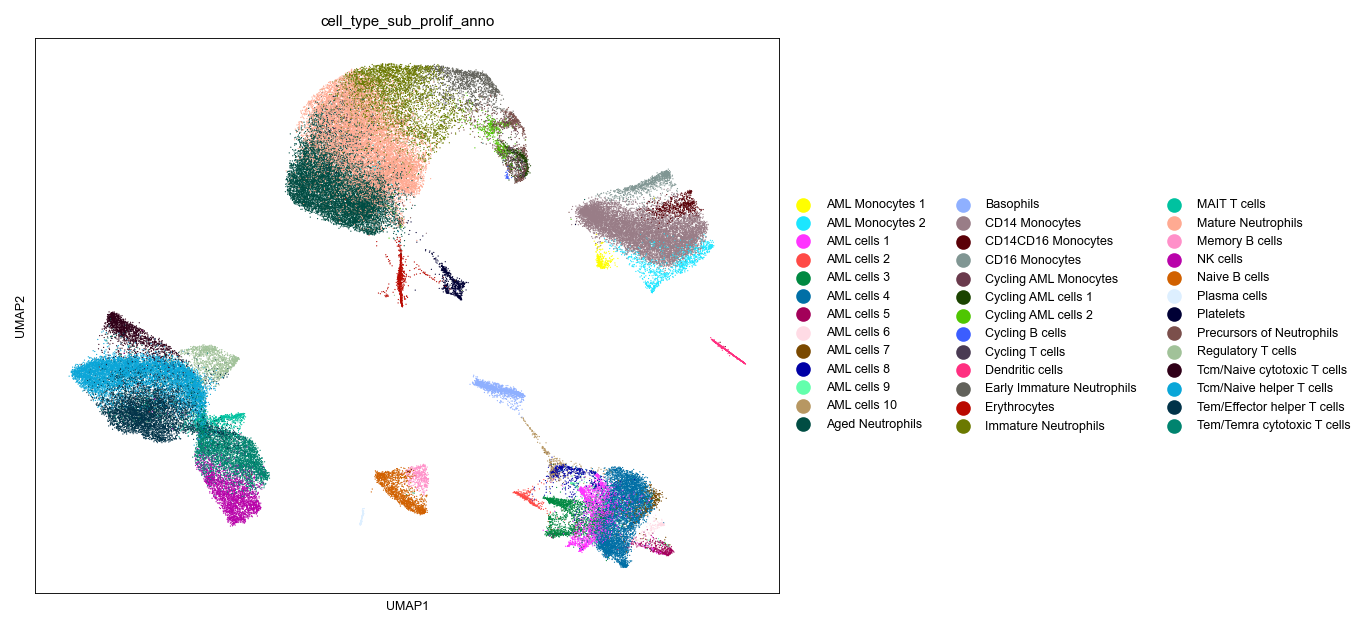

In [160]:
sc.pl.umap(adata_raw, color='cell_type_sub_prolif_anno')

In [161]:
#save obs!!!
#
#'cell_type_sub_prolif_anno' in global adata
#'cell_type_refined2' in subset adata

fname = 'AML/anno_obs_info_%dx%d_%s'%(adata_raw.obs.shape[0],adata_raw.obs.shape[1],rz.now())
print(fname)
rz.save_df(adata_raw.obs,fname)

fname = 'AML/anno_obs_info_%dx%d_%s'%(bdata.obs.shape[0],bdata.obs.shape[1],rz.now())
print(fname)
rz.save_df(bdata.obs,fname)

AML/anno_obs_info_86447x39_250127_18h19
AML/anno_obs_info_2167x162_250127_18h19
